# CMIP6 OMIP: 0-200m Heat & Salt Content Bias
 - Ingests large multi-model ensemble of CMIP6 OMIP runs from NCAR data catalog
 - Regrids to standard 1x1
 - Computes climatological bias relative to EN4

In [1]:
%matplotlib inline
import os
import shutil
from glob import glob
import cftime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import intake
import cf_xarray
import pop_tools
#import esmlab
#import util
import warnings
warnings.filterwarnings('ignore')

In [2]:
xr.__version__

'0.19.0'

In [3]:
import dask
dask.__version__

'2021.09.0'

In [4]:
cf_xarray.__version__

'0.6.1'

## Create Dask Cluster

In [12]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [5]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(20) 

In [6]:
cluster

##
## Access NCAR CMIP6 Data Holdings using intake
- see https://intake-esm.readthedocs.io/en/latest/index.html
- see https://ncar.github.io/esds/posts/2021/intake_cmip6_debug/

In [7]:
# Point to the catalog file
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json'

# Open the catalog using intake
col = intake.open_esm_datastore(catalog_file)

In [8]:
import pprint

# Print out a top-level summary of what's in this catalog
uni_dict = col.unique(["source_id", "experiment_id", "table_id"])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 130,
                   'values': ['hist-nat', 'esm-ssp585-ssp126Lu', 'aqua-p4K',
                              'amip-lfmip-pdLC', 'amip-lfmip-rmLC', 'G6solar',
                              'piControl', 'pdSST-futArcSIC', 'hist-1950',
                              'pdSST-piAntSIC', '1pctCO2-rad', 'piClim-NOx',
                              'ssp534-over', 'pa-pdSIC', 'piClim-aer',
                              'aqua-control', 'omip2', 'amip-p4K',
                              'midHolocene', 'land-cCO2', 'land-crop-noFert',
                              'modelSST-futArcSIC', 'ssp434', 'abrupt-0p5xCO2',
                              'pa-futArcSIC', 'land-noWoodHarv', 'hist-piNTCF',
                              'hist-aer', 'amip-lwoff', 'omip1', 'hist-noLu',
                              'land-hist-cruNcep', 'abrupt-2xCO2',
                              'amip-piForcing', 'esm-1pct-brch-1000PgC',
                              'pa-futAntSIC', 'histSST-piCH4',
  

In [9]:
# Inspect what the OMIP holdings look like
col.df[col.df.experiment_id == 'omip2']

activity_id institution_id    source_id experiment_id member_id  \
1490230        OMIP            CAS  FGOALS-f3-H         omip2  r1i1p1f1   
1490231        OMIP            CAS  FGOALS-f3-H         omip2  r1i1p1f1   
1490232        OMIP            CAS  FGOALS-f3-H         omip2  r1i1p1f1   
1490233        OMIP            CAS  FGOALS-f3-H         omip2  r1i1p1f1   
1490234        OMIP            CAS  FGOALS-f3-H         omip2  r1i1p1f1   
...             ...            ...          ...           ...       ...   
1668500        OMIP            NCC   NorESM2-LM         omip2  r1i1p1f1   
1668501        OMIP            NCC   NorESM2-LM         omip2  r1i1p1f1   
1668502        OMIP            NCC   NorESM2-LM         omip2  r1i1p1f1   
1668503        OMIP            NCC   NorESM2-LM         omip2  r1i1p1f1   
1668504        OMIP            NCC   NorESM2-LM         omip2  r1i1p1f1   

        table_id     variable_id grid_label  dcpp_init_year    version  \
1490230     Oday              so         gn             NaN  v20210316   
1490231     Oday              so         gn             NaN  v20210316   
1490232     Oday              so         gn             NaN  v20210316   
1490233     Oday              so         gn             NaN  v20210316   
1490234     Oday              so         gn             NaN  v20210316   
...          ...             ...        ...             ...        ...   
1668500    SImon  sndmasswindrif         gn             NaN  v20190920   
1668501    SImon  sndmasswindrif         gn             NaN  v20190920   
1668502    SImon  sndmasswindrif         gn             NaN  v20190920   
1668503    SImon  sndmasswindrif         gn             NaN  v20190920   
1668504    SImon  sndmasswindrif         gn             NaN  v20190920   

                time_range                                               path  
1490230  19580101-19580101  /glade/collections/cmip/CMIP6/OMIP/CAS/FGOALS-...  
1490231  19580102-19580102  /glade/collections/cmip/CMIP6/OMIP/CAS/FGOALS-...  
1490232  19580103-19580103  /glade/collections/cmip/CMIP6/OMIP/CAS/FGOALS-...  
1490233  19580104-19580104  /glade/collections/cmip/CMIP6/OMIP/CAS/FGOALS-...  
1490234  19580105-19580105  /glade/collections/cmip/CMIP6/OMIP/CAS/FGOALS-...  
...                    ...                                                ...  
1668500      197001-197912  /glade/collections/cmip/CMIP6/OMIP/NCC/NorESM2...  
1668501      198001-198912  /glade/collections/cmip/CMIP6/OMIP/NCC/NorESM2...  
1668502      199001-199912  /glade/collections/cmip/CMIP6/OMIP/NCC/NorESM2...  
1668503      200001-200912  /glade/collections/cmip/CMIP6/OMIP/NCC/NorESM2...  
1668504      201001-201812  /glade/collections/cmip/CMIP6/OMIP/NCC/NorESM2...  

[115438 rows x 12 columns]

In [10]:
# Print out a summary of OMIP1 data
uni_dict = col.search(experiment_id='omip1').unique(["source_id", "table_id"])
pprint.pprint(uni_dict, compact=True)

{'source_id': {'count': 18,
               'values': ['IPSL-CM6A-LR', 'CESM2', 'CNRM-ESM2-1', 'MRI-ESM2-0',
                          'EC-Earth3', 'MIROC-ES2L', 'MIROC6', 'CMCC-CM2-SR5',
                          'GFDL-OM4p5B', 'CNRM-CM6-1', 'CanESM5-CanOE',
                          'GFDL-CM4', 'CAS-ESM2-0', 'CMCC-ESM2', 'NorESM2-LM',
                          'FIO-ESM-2-0', 'FGOALS-f3-L', 'CanESM5']},
 'table_id': {'count': 9,
              'values': ['Odec', 'Omon', 'Emon', 'Ofx', 'Oday', 'Eday', 'SImon',
                         'SIday', 'Oyr']}}


In [11]:
# Print out a summary of OMIP2 data
uni_dict = col.search(experiment_id='omip2').unique(["source_id", "table_id"])
pprint.pprint(uni_dict, compact=True)

{'source_id': {'count': 13,
               'values': ['CNRM-CM6-1-HR', 'ACCESS-OM2', 'FGOALS-f3-H',
                          'EC-Earth3', 'MIROC6', 'MRI-ESM2-0', 'CMCC-CM2-SR5',
                          'CNRM-CM6-1', 'CMCC-CM2-HR4', 'ACCESS-OM2-025',
                          'CESM2', 'NorESM2-LM', 'FGOALS-f3-L']},
 'table_id': {'count': 8,
              'values': ['Omon', 'Emon', 'Ofx', 'Oday', 'Eday', 'SImon',
                         'SIday', 'Oyr']}}


### Here is where we define a dataset dictionary containing specific fields to be analyzed
- First, aggregate all available data from the catalog

In [31]:
# Define the omip1 query
query = dict(variable_id=["thetao", "so"],experiment_id=["omip1"],table_id=["Omon"])

# use require_all_on so that entries must include both variable_id's
cat_omip1 = col.search(require_all_on=["source_id"], **query)

# print a summary of this dataset
uni_dict = cat_omip1.unique(["source_id", "table_id","grid_label"])
pprint.pprint(uni_dict, compact=True)

{'grid_label': {'count': 3, 'values': ['gn', 'gr1', 'gr']},
 'source_id': {'count': 18,
               'values': ['IPSL-CM6A-LR', 'GFDL-OM4p5B', 'MRI-ESM2-0',
                          'EC-Earth3', 'CAS-ESM2-0', 'MIROC-ES2L',
                          'CMCC-CM2-SR5', 'MIROC6', 'CNRM-CM6-1',
                          'CanESM5-CanOE', 'CanESM5', 'GFDL-CM4', 'CESM2',
                          'CMCC-ESM2', 'NorESM2-LM', 'FIO-ESM-2-0',
                          'FGOALS-f3-L', 'CNRM-ESM2-1']},
 'table_id': {'count': 1, 'values': ['Omon']}}


In [25]:
cat_omip1['OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn']

- Next, create a dataset dictionary. Aggregation errors may occur that require manual elimination of some df entries. This is because the code that generates the catalog has some bugs that will hopefully be fixed in future. Iterate until to_dataset_dict() call is successful.

In [32]:
# This collection includes some entries that cause aggregation errors. CISL software
# engineers are looking into fixes for a more robust data catalog. For now, use manual work-arounds
# to eliminate duplicate/bad data from the catalog. Problem keys include:
#  OMIP.IPSL.IPSL-CM6A-LR.omip1.Omon.gn
#  OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn

indices_to_drop = np.concatenate((np.array([95,105]),np.arange(1198,1224,1)))
cat_omip1.df = cat_omip1.df.drop(indices_to_drop)

# Create a corresponding dataset dictionary
dsetdict_omip1 = cat_omip1.to_dataset_dict(cdf_kwargs={'chunks': {'time':12},'decode_times': True, 'use_cftime': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [33]:
# Define the omip2 query
query = dict(variable_id=["thetao", "so"],experiment_id=["omip2"],table_id=["Omon"])

# use require_all_on so that entries must include both variable_id's
cat_omip2 = col.search(require_all_on=["source_id"], **query)

# print a summary of this dataset
uni_dict = cat_omip2.unique(["source_id", "table_id","grid_label"])
pprint.pprint(uni_dict, compact=True)

{'grid_label': {'count': 2, 'values': ['gn', 'gr']},
 'source_id': {'count': 13,
               'values': ['CNRM-CM6-1-HR', 'ACCESS-OM2', 'FGOALS-f3-H',
                          'EC-Earth3', 'MIROC6', 'MRI-ESM2-0', 'CMCC-CM2-SR5',
                          'CNRM-CM6-1', 'CMCC-CM2-HR4', 'ACCESS-OM2-025',
                          'CESM2', 'NorESM2-LM', 'FGOALS-f3-L']},
 'table_id': {'count': 1, 'values': ['Omon']}}


In [34]:

# Create a corresponding dataset dictionary
dsetdict_omip2 = cat_omip2.to_dataset_dict(cdf_kwargs={'chunks': {'time':12},'decode_times': True, 'use_cftime': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


- Summary of OMIP1 Keys

In [35]:
omip1_keys = [key for key in dsetdict_omip1.keys()]
len(omip1_keys),omip1_keys

(24,
 ['OMIP.CAS.FGOALS-f3-L.omip1.Omon.gn',
  'OMIP.IPSL.IPSL-CM6A-LR.omip1.Omon.gn',
  'OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn',
  'OMIP.FIO-QLNM.FIO-ESM-2-0.omip1.Omon.gn',
  'OMIP.MIROC.MIROC6.omip1.Omon.gn',
  'OMIP.MIROC.MIROC-ES2L.omip1.Omon.gn',
  'OMIP.CAS.CAS-ESM2-0.omip1.Omon.gn',
  'OMIP.NCAR.CESM2.omip1.Omon.gr',
  'OMIP.MRI.MRI-ESM2-0.omip1.Omon.gn',
  'OMIP.CNRM-CERFACS.CNRM-ESM2-1.omip1.Omon.gn',
  'OMIP.NCC.NorESM2-LM.omip1.Omon.gn',
  'OMIP.NOAA-GFDL.GFDL-CM4.omip1.Omon.gn',
  'OMIP.NCAR.CESM2.omip1.Omon.gn',
  'OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1.Omon.gn',
  'OMIP.MIROC.MIROC-ES2L.omip1.Omon.gr1',
  'OMIP.NCC.NorESM2-LM.omip1.Omon.gr',
  'OMIP.CCCma.CanESM5-CanOE.omip1.Omon.gn',
  'OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1.Omon.gr',
  'OMIP.MRI.MRI-ESM2-0.omip1.Omon.gr',
  'OMIP.NOAA-GFDL.GFDL-CM4.omip1.Omon.gr',
  'OMIP.CMCC.CMCC-CM2-SR5.omip1.Omon.gn',
  'OMIP.CMCC.CMCC-ESM2.omip1.Omon.gn',
  'OMIP.EC-Earth-Consortium.EC-Earth3.omip1.Omon.gn',
  'OMIP.CCCma.CanESM5.omip1.O

- Summary of OMIP2 Keys

In [36]:
omip2_keys = [key for key in dsetdict_omip2.keys()]
len(omip2_keys),omip2_keys

(16,
 ['OMIP.MRI.MRI-ESM2-0.omip2.Omon.gn',
  'OMIP.CNRM-CERFACS.CNRM-CM6-1-HR.omip2.Omon.gn',
  'OMIP.CAS.FGOALS-f3-H.omip2.Omon.gr',
  'OMIP.CAS.FGOALS-f3-L.omip2.Omon.gn',
  'OMIP.CMCC.CMCC-CM2-SR5.omip2.Omon.gn',
  'OMIP.NCC.NorESM2-LM.omip2.Omon.gr',
  'OMIP.NCAR.CESM2.omip2.Omon.gn',
  'OMIP.EC-Earth-Consortium.EC-Earth3.omip2.Omon.gn',
  'OMIP.NCAR.CESM2.omip2.Omon.gr',
  'OMIP.CSIRO-COSIMA.ACCESS-OM2-025.omip2.Omon.gn',
  'OMIP.NCC.NorESM2-LM.omip2.Omon.gn',
  'OMIP.MRI.MRI-ESM2-0.omip2.Omon.gr',
  'OMIP.CNRM-CERFACS.CNRM-CM6-1.omip2.Omon.gn',
  'OMIP.CMCC.CMCC-CM2-HR4.omip2.Omon.gn',
  'OMIP.MIROC.MIROC6.omip2.Omon.gn',
  'OMIP.CSIRO-COSIMA.ACCESS-OM2.omip2.Omon.gn'])

##
## Inspect and Refine Datasets
### Overview of Grid Information for 'gr' and 'gr1' datasets

In [37]:
# show grid info for regular-gridded OMIP1 data
for key in dsetdict_omip1.keys():
    if (dsetdict_omip1[key].grid_label != 'gn'):
        print(key)
        dims_mtzyx = ['member_id','T','Z','Y','X']
        dsdims = dsetdict_omip1[key].cf.dims
        dimdict = {dim:dsdims[dim] for dim in dims_mtzyx}
        print(dimdict)

OMIP.NCAR.CESM2.omip1.Omon.gr
{'member_id': 2, 'T': 4464, 'Z': 33, 'Y': 180, 'X': 360}
OMIP.MIROC.MIROC-ES2L.omip1.Omon.gr1
{'member_id': 1, 'T': 3720, 'Z': 63, 'Y': 180, 'X': 360}
OMIP.NCC.NorESM2-LM.omip1.Omon.gr
{'member_id': 1, 'T': 3720, 'Z': 70, 'Y': 385, 'X': 360}
OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1.Omon.gr
{'member_id': 1, 'T': 3600, 'Z': 35, 'Y': 180, 'X': 360}
OMIP.MRI.MRI-ESM2-0.omip1.Omon.gr
{'member_id': 3, 'T': 4464, 'Z': 61, 'Y': 180, 'X': 360}
OMIP.NOAA-GFDL.GFDL-CM4.omip1.Omon.gr
{'member_id': 1, 'T': 3600, 'Z': 35, 'Y': 180, 'X': 360}


In [38]:
# show grid info for regular-gridded OMIP2 data
for key in dsetdict_omip2.keys():
    if (dsetdict_omip2[key].grid_label != 'gn'):
        print(key)
        dims_mtzyx = ['member_id','T','Z','Y','X']
        dsdims = dsetdict_omip2[key].cf.dims
        dimdict = {dim:dsdims[dim] for dim in dims_mtzyx}
        print(dimdict)

OMIP.CAS.FGOALS-f3-H.omip2.Omon.gr
{'member_id': 1, 'T': 732, 'Z': 55, 'Y': 720, 'X': 1440}
OMIP.NCC.NorESM2-LM.omip2.Omon.gr
{'member_id': 1, 'T': 4392, 'Z': 70, 'Y': 385, 'X': 360}
OMIP.NCAR.CESM2.omip2.Omon.gr
{'member_id': 1, 'T': 4392, 'Z': 33, 'Y': 180, 'X': 360}
OMIP.MRI.MRI-ESM2-0.omip2.Omon.gr
{'member_id': 5, 'T': 4392, 'Z': 61, 'Y': 180, 'X': 360}


### If multiple versions of dataset exist, only keep regridded version

In [39]:
def keys_tokeep(dsdict):
    ''' function sorts through the keys of this dataset dictionary,
    eliminating keys with grid_label 'gn' if equivalent version
    exists that has grid_label 'gr' or 'gr1'.
    ''' 
    keylist = []
    gridlist = []
    for key in dsdict.keys():
        print(key)
        elements = key.split('.')
        keybase = key.replace('.'+elements[-1],'')
        foundmatch = False
        for i in range(len(keylist)):
            if keybase in keylist[i]:
                foundmatch = True
                if ('gr' in elements[-1]) & (gridlist[i]=='gn'):
                    print('  replacing '+keylist[i]+' with '+key)
                    keylist[i] = key
                    gridlist[i] = elements[-1]
                else:
                    print('  ignoring '+key)
        if (not foundmatch):
            print('  adding '+key)
            keylist.append(key)
            gridlist.append(elements[-1])        
    return keylist

In [40]:
omip1_keepkeys = keys_tokeep(dsetdict_omip1)

OMIP.CAS.FGOALS-f3-L.omip1.Omon.gn
  adding OMIP.CAS.FGOALS-f3-L.omip1.Omon.gn
OMIP.IPSL.IPSL-CM6A-LR.omip1.Omon.gn
  adding OMIP.IPSL.IPSL-CM6A-LR.omip1.Omon.gn
OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn
  adding OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn
OMIP.FIO-QLNM.FIO-ESM-2-0.omip1.Omon.gn
  adding OMIP.FIO-QLNM.FIO-ESM-2-0.omip1.Omon.gn
OMIP.MIROC.MIROC6.omip1.Omon.gn
  adding OMIP.MIROC.MIROC6.omip1.Omon.gn
OMIP.MIROC.MIROC-ES2L.omip1.Omon.gn
  adding OMIP.MIROC.MIROC-ES2L.omip1.Omon.gn
OMIP.CAS.CAS-ESM2-0.omip1.Omon.gn
  adding OMIP.CAS.CAS-ESM2-0.omip1.Omon.gn
OMIP.NCAR.CESM2.omip1.Omon.gr
  adding OMIP.NCAR.CESM2.omip1.Omon.gr
OMIP.MRI.MRI-ESM2-0.omip1.Omon.gn
  adding OMIP.MRI.MRI-ESM2-0.omip1.Omon.gn
OMIP.CNRM-CERFACS.CNRM-ESM2-1.omip1.Omon.gn
  adding OMIP.CNRM-CERFACS.CNRM-ESM2-1.omip1.Omon.gn
OMIP.NCC.NorESM2-LM.omip1.Omon.gn
  adding OMIP.NCC.NorESM2-LM.omip1.Omon.gn
OMIP.NOAA-GFDL.GFDL-CM4.omip1.Omon.gn
  adding OMIP.NOAA-GFDL.GFDL-CM4.omip1.Omon.gn
OMIP.NCAR.CESM2.om

In [41]:
omip2_keepkeys = keys_tokeep(dsetdict_omip2)

OMIP.MRI.MRI-ESM2-0.omip2.Omon.gn
  adding OMIP.MRI.MRI-ESM2-0.omip2.Omon.gn
OMIP.CNRM-CERFACS.CNRM-CM6-1-HR.omip2.Omon.gn
  adding OMIP.CNRM-CERFACS.CNRM-CM6-1-HR.omip2.Omon.gn
OMIP.CAS.FGOALS-f3-H.omip2.Omon.gr
  adding OMIP.CAS.FGOALS-f3-H.omip2.Omon.gr
OMIP.CAS.FGOALS-f3-L.omip2.Omon.gn
  adding OMIP.CAS.FGOALS-f3-L.omip2.Omon.gn
OMIP.CMCC.CMCC-CM2-SR5.omip2.Omon.gn
  adding OMIP.CMCC.CMCC-CM2-SR5.omip2.Omon.gn
OMIP.NCC.NorESM2-LM.omip2.Omon.gr
  adding OMIP.NCC.NorESM2-LM.omip2.Omon.gr
OMIP.NCAR.CESM2.omip2.Omon.gn
  adding OMIP.NCAR.CESM2.omip2.Omon.gn
OMIP.EC-Earth-Consortium.EC-Earth3.omip2.Omon.gn
  adding OMIP.EC-Earth-Consortium.EC-Earth3.omip2.Omon.gn
OMIP.NCAR.CESM2.omip2.Omon.gr
  replacing OMIP.NCAR.CESM2.omip2.Omon.gn with OMIP.NCAR.CESM2.omip2.Omon.gr
OMIP.CSIRO-COSIMA.ACCESS-OM2-025.omip2.Omon.gn
  adding OMIP.CSIRO-COSIMA.ACCESS-OM2-025.omip2.Omon.gn
OMIP.NCC.NorESM2-LM.omip2.Omon.gn
  ignoring OMIP.NCC.NorESM2-LM.omip2.Omon.gn
OMIP.MRI.MRI-ESM2-0.omip2.Omon.gr
  rep

In [42]:
len(omip1_keys),len(omip1_keepkeys),omip1_keepkeys

(24,
 18,
 ['OMIP.CAS.FGOALS-f3-L.omip1.Omon.gn',
  'OMIP.IPSL.IPSL-CM6A-LR.omip1.Omon.gn',
  'OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn',
  'OMIP.FIO-QLNM.FIO-ESM-2-0.omip1.Omon.gn',
  'OMIP.MIROC.MIROC6.omip1.Omon.gn',
  'OMIP.MIROC.MIROC-ES2L.omip1.Omon.gr1',
  'OMIP.CAS.CAS-ESM2-0.omip1.Omon.gn',
  'OMIP.NCAR.CESM2.omip1.Omon.gr',
  'OMIP.MRI.MRI-ESM2-0.omip1.Omon.gr',
  'OMIP.CNRM-CERFACS.CNRM-ESM2-1.omip1.Omon.gn',
  'OMIP.NCC.NorESM2-LM.omip1.Omon.gr',
  'OMIP.NOAA-GFDL.GFDL-CM4.omip1.Omon.gr',
  'OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1.Omon.gr',
  'OMIP.CCCma.CanESM5-CanOE.omip1.Omon.gn',
  'OMIP.CMCC.CMCC-CM2-SR5.omip1.Omon.gn',
  'OMIP.CMCC.CMCC-ESM2.omip1.Omon.gn',
  'OMIP.EC-Earth-Consortium.EC-Earth3.omip1.Omon.gn',
  'OMIP.CCCma.CanESM5.omip1.Omon.gn'])

In [43]:
len(omip2_keys),len(omip2_keepkeys),omip2_keepkeys

(16,
 13,
 ['OMIP.MRI.MRI-ESM2-0.omip2.Omon.gr',
  'OMIP.CNRM-CERFACS.CNRM-CM6-1-HR.omip2.Omon.gn',
  'OMIP.CAS.FGOALS-f3-H.omip2.Omon.gr',
  'OMIP.CAS.FGOALS-f3-L.omip2.Omon.gn',
  'OMIP.CMCC.CMCC-CM2-SR5.omip2.Omon.gn',
  'OMIP.NCC.NorESM2-LM.omip2.Omon.gr',
  'OMIP.NCAR.CESM2.omip2.Omon.gr',
  'OMIP.EC-Earth-Consortium.EC-Earth3.omip2.Omon.gn',
  'OMIP.CSIRO-COSIMA.ACCESS-OM2-025.omip2.Omon.gn',
  'OMIP.CNRM-CERFACS.CNRM-CM6-1.omip2.Omon.gn',
  'OMIP.CMCC.CMCC-CM2-HR4.omip2.Omon.gn',
  'OMIP.MIROC.MIROC6.omip2.Omon.gn',
  'OMIP.CSIRO-COSIMA.ACCESS-OM2.omip2.Omon.gn'])

### Check vertical grid attributes of keeper datasets
- Vertically-averaging code below assumes z-level coordinates in units of "m". Need to check that all keys in the dictionary conform to that expectation. Note that MIROC data has been regridded to level coordinates and units appear to be "m" (units not given!).

In [44]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

for key in omip1_keepkeys:
    print(color.BOLD+key+color.END)
    ds = dsetdict_omip1[key]
    ds = ds.cf.guess_coord_axis()
    print(ds.cf["Z"].attrs)
    #print(ds['vertical'].attrs)

OMIP.CAS.FGOALS-f3-L.omip1.Omon.gn
{'axis': 'Z', 'bounds': 'lev_bnds', 'units': 'm', 'positive': 'down', 'long_name': 'ocean depth coordinate', 'standard_name': 'depth'}
OMIP.IPSL.IPSL-CM6A-LR.omip1.Omon.gn
{'axis': 'Z', 'name': 'olevel', 'long_name': 'Vertical T levels', 'units': 'm', 'positive': 'down', 'bounds': 'olevel_bounds'}
OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn
{'axis': 'Z', 'name': 'lev', 'long_name': 'Vertical T levels', 'units': 'm', 'positive': 'down', 'bounds': 'lev_bounds'}
OMIP.FIO-QLNM.FIO-ESM-2-0.omip1.Omon.gn
{'axis': 'Z', 'bounds': 'lev_bnds', 'units': 'm', 'positive': 'down', 'long_name': 'ocean depth coordinate', 'standard_name': 'depth'}
OMIP.MIROC.MIROC6.omip1.Omon.gn
{'axis': 'Z', 'bounds': 'lev_bnds', 'long_name': 'ocean sigma over z coordinate', 'standard_name': 'ocean_sigma_z_coordinate', 'formula': 'for k <= nsigma: z(n,k,j,i) = eta(n,j,i) + sigma(k)*(min(depth_c,depth(j,i))+eta(n,j,i)) ; for k > nsigma: z(n,k,j,i) = zlev(k)', 'formula_terms': 'sigma: s

##
## Compute depth-average Temperature & Salinity

In [45]:
def limit_depth_of_field(level_bounds, field, depth_limit):
    level_bounds_limited = level_bounds.where(level_bounds < depth_limit, depth_limit)
    delta_level = abs(level_bounds_limited[:, 1] - level_bounds_limited[:, 0])
    delta_level_limited = delta_level.where(delta_level != 0, drop=True)
    field_limited = field.where(delta_level != 0, drop=True)
    return delta_level_limited, field_limited

def compute_depthavg_dsdict(ds,keys,field,depth=100):
    """
    Compute mean over depth for field, for each dataset
    within a DataSet dict. Returns a new DataArray dict.
    """
    dsnew = {}
    newvarname = field+'_'+str(depth)+'m_mean'
    for key in keys:
        ds0 = ds[key].cf.guess_coord_axis()
        zbnds_name = ds0.cf['Z'].attrs['bounds']
        zbnds = ds0[zbnds_name]
        dz,data = limit_depth_of_field(zbnds,ds0[field],depth)
        data_mean = (data*dz).cf.sum('Z',skipna=False)/dz.cf.sum('Z')
        data_mean.name = newvarname
        dsnew[key] = data_mean
    return dsnew

def compute_depthavg_ds(ds,field,depth_coord,depth=100):
    """
    Compute mean over depth for field.
    """
    newvarname = field+'_'+str(depth)+'m_mean'
    dep_bnds = depth_coord+'_bnds'
    dz,data = limit_depth_of_field(ds[dep_bnds],ds[field],depth)
    data_mean = (data*dz).sum(depth_coord,skipna=False)/dz.sum(depth_coord)
    ds[newvarname] = data_mean
    ds[newvarname].attrs['units'] = data.attrs['units']
    return ds

In [46]:
dadictomip1_thetao200 = compute_depthavg_dsdict(dsetdict_omip1,omip1_keepkeys,'thetao',200)
dadictomip1_so200 = compute_depthavg_dsdict(dsetdict_omip1,omip1_keepkeys,'so',200)
dadictomip2_thetao200 = compute_depthavg_dsdict(dsetdict_omip2,omip2_keepkeys,'thetao',200)
dadictomip2_so200 = compute_depthavg_dsdict(dsetdict_omip2,omip2_keepkeys,'so',200)

##
## EN4 Observations

In [47]:
fin = '/glade/p/cgd/oce/people/yeager/OBS/MetOffice.EN4/v4.2.1/monthly/EN.4.2.1.f.analysis.g10.????.nc'
ds_en4 = xr.open_mfdataset(fin,chunks={'time':12},combine='by_coords',data_vars='minimal',parallel=True)

In [48]:
# Create 30-year monthly climatology
ds_en4 = ds_en4[['temperature','salinity','time_bnds','depth_bnds']].sel(time=slice('1978','2007'))

# Following line is needed to circumvent this xarray issue:
#  https://github.com/pydata/xarray/issues/2145#issuecomment-391114129
ds_en4 = ds_en4.set_coords('depth_bnds')
ds_en4 = ds_en4.groupby('time.month',squeeze=True).mean('time',keep_attrs=True)
ds_en4 = ds_en4.rename({'temperature':'thetao','salinity':'so'})
ds_en4 = ds_en4.load()

In [49]:
# Add depth-average fields to Dataset
ds_en4['thetao'] = ds_en4['thetao'] - 273.15
ds_en4['thetao'].attrs['units'] = 'degC'
ds_en4 = compute_depthavg_ds(ds_en4,'thetao','depth',200)
ds_en4 = compute_depthavg_ds(ds_en4,'so','depth',200)
ds_en4 = ds_en4[['thetao_200m_mean','so_200m_mean']]

In [31]:
# Write to netcdf
#fout = '/glade/scratch/yeager/OMDP/EN4_1978-2007clim_200m.nc'
#ds_en4.fillna(-9999).to_netcdf(fout,encoding={'thetao_200m_mean': {'dtype': 'float', '_FillValue': -9999},'so_200m_mean': {'dtype': 'float', '_FillValue': -9999}})

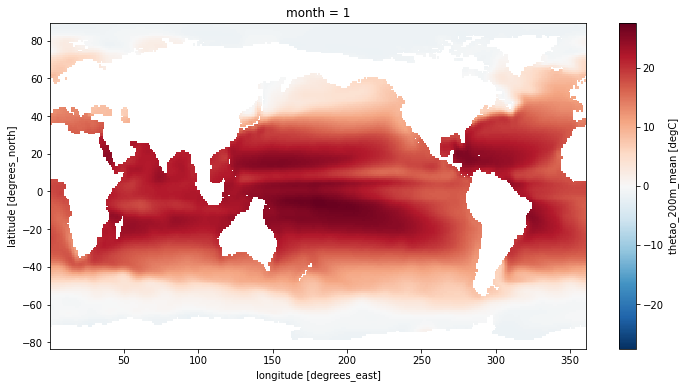

In [50]:
ds_en4['thetao_200m_mean'].isel(month=0).plot(aspect=2, size=6)

In [51]:
ds_en4['mask'] = xr.where(ds_en4['thetao_200m_mean'].isnull().all('month'),0,1)

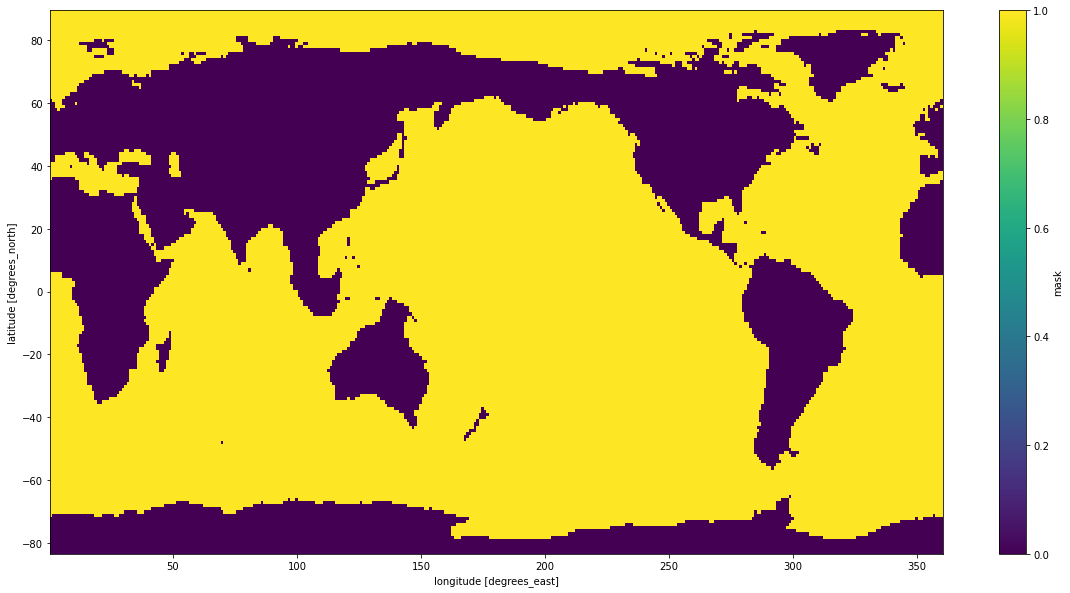

In [52]:
ds_en4.mask.plot(aspect=2, size=10)

##
### Regrid to standard 1x1 grid

In [53]:
import xesmf as xe
woa1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90.5, 1.0)),
                     'lon': (['lon'], np.arange(0.5, 360.5, 1.0)),
                    'mask': (['lat','lon'],np.ones((180, 360)))})

In [54]:
regrid_en4 = xe.Regridder(ds_en4, woa1x1, method='bilinear',periodic=True)
regrid_en4  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_173x360_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (173, 360) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [55]:
ds_en4_1x1 = regrid_en4(ds_en4.drop('mask'),keep_attrs=True)

In [56]:
# Write to netcdf
fout = '/glade/scratch/yeager/OMDP/EN4_1978-2007clim_200m_1x1.nc'
ds_en4_1x1.to_netcdf(fout)

In [57]:
ds_en4_1x1

<xarray.Dataset>
Dimensions:           (month: 12, lat: 180, lon: 360)
Coordinates:
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon               (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    thetao_200m_mean  (month, lat, lon) float32 nan nan nan ... -1.221 -1.22
    so_200m_mean      (month, lat, lon) float32 nan nan nan ... 33.42 33.42
Attributes: (12/23)
    Conventions:            CF-1.0
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             None
    institution:            UK Met Office
    contact:                Simon Good - simon.good@metoffice.gov.uk
    ...                     ...
    northernmost_latitude:  89.5
    westernmost_longitude:  0.5
    easternmost_longitude:  362.5
    file_quality_index:     0
    NCO:                    netCDF Operators version 4.9.5 (Homepage = http:/...
    regrid_method:          bilinear

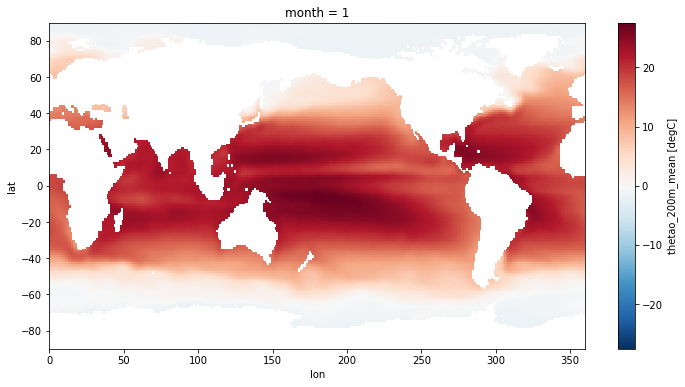

In [58]:
ds_en4_1x1.thetao_200m_mean.isel(month=0).plot(aspect=2, size=6)

##
## OMIP 200m thetao and so anomalies on regular grid

In [59]:
for key in omip1_keepkeys:
    ds = dsetdict_omip1[key]
    print(key+':'+ds.attrs['nominal_resolution'])

OMIP.CAS.FGOALS-f3-L.omip1.Omon.gn:100 km
OMIP.IPSL.IPSL-CM6A-LR.omip1.Omon.gn:100 km
OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn:100 km
OMIP.FIO-QLNM.FIO-ESM-2-0.omip1.Omon.gn:100 km
OMIP.MIROC.MIROC6.omip1.Omon.gn:100 km
OMIP.MIROC.MIROC-ES2L.omip1.Omon.gr1:1x1 degree
OMIP.CAS.CAS-ESM2-0.omip1.Omon.gn:100 km
OMIP.NCAR.CESM2.omip1.Omon.gr:1x1 degree
OMIP.MRI.MRI-ESM2-0.omip1.Omon.gr:100 km
OMIP.CNRM-CERFACS.CNRM-ESM2-1.omip1.Omon.gn:100 km
OMIP.NCC.NorESM2-LM.omip1.Omon.gr:100 km
OMIP.NOAA-GFDL.GFDL-CM4.omip1.Omon.gr:1x1 degree
OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1.Omon.gr:1x1 degree
OMIP.CCCma.CanESM5-CanOE.omip1.Omon.gn:100 km
OMIP.CMCC.CMCC-CM2-SR5.omip1.Omon.gn:100 km
OMIP.CMCC.CMCC-ESM2.omip1.Omon.gn:100 km
OMIP.EC-Earth-Consortium.EC-Earth3.omip1.Omon.gn:100 km
OMIP.CCCma.CanESM5.omip1.Omon.gn:100 km


In [60]:
for key in omip2_keepkeys:
    ds = dsetdict_omip2[key]
    print(key+':'+ds.attrs['nominal_resolution'])

OMIP.MRI.MRI-ESM2-0.omip2.Omon.gr:100 km
OMIP.CNRM-CERFACS.CNRM-CM6-1-HR.omip2.Omon.gn:25 km
OMIP.CAS.FGOALS-f3-H.omip2.Omon.gr:25 km
OMIP.CAS.FGOALS-f3-L.omip2.Omon.gn:100 km
OMIP.CMCC.CMCC-CM2-SR5.omip2.Omon.gn:100 km
OMIP.NCC.NorESM2-LM.omip2.Omon.gr:100 km
OMIP.NCAR.CESM2.omip2.Omon.gr:1x1 degree
OMIP.EC-Earth-Consortium.EC-Earth3.omip2.Omon.gn:100 km
OMIP.CSIRO-COSIMA.ACCESS-OM2-025.omip2.Omon.gn:25 km
OMIP.CNRM-CERFACS.CNRM-CM6-1.omip2.Omon.gn:100 km
OMIP.CMCC.CMCC-CM2-HR4.omip2.Omon.gn:25 km
OMIP.MIROC.MIROC6.omip2.Omon.gn:100 km
OMIP.CSIRO-COSIMA.ACCESS-OM2.omip2.Omon.gn:100 km


In [61]:
def forcing_cycles(expid,nt):
    ''' Function to determine the number and year range of forcing
    cycles included in this OMIP data array.'''
    maxcycles = 10
    if (expid=="omip1" or expid=="omip1-spunup"):
        # For OMIP1, we expect a 1948-2009 (62-year) forcing cycle = 744 mon
        # but some groups submitted a 1948-2007 (60-year) cycle = 720 mon
        # and MIROC submitted a 1958-2009 (52 year) cycle = 624 mon
        if (nt % 744 == 0):
            nyear = 62
            yearrange = (1948,2009)
        elif (nt % 720 == 0):
            nyear = 60
            yearrange = (1948,2007)
        elif (nt % 624 == 0):
            nyear = 52
            yearrange = (1958,2009)
        else:
            raise ValueError('ERROR: could not determine OMIP1 forcing cycle')
    elif (expid=="omip2" or expid=="omip2-spunup"):
        # For OMIP2, we expect a 1958-2018 (61-year) forcing cycle = 732 mon
        if (nt % 732 == 0):
            nyear = 61
            yearrange = (1958,2018)
        else:
            raise ValueError('ERROR: could not determine OMIP2 forcing cycle')
    else:
        raise ValueError('ERROR: experiment_id not recognized')
    ntmon = nyear*12*np.arange(1,maxcycles+1,1)
    findcyc = np.where(nt==ntmon)
    ncyc = findcyc[0][0] + 1
    print('  found '+str(ncyc)+' forcing cyles spanning '+str(yearrange))
    return ncyc,yearrange

In [62]:
def regrid1x1(gridid,da):
    ''' Function determines whether regridding to regular 1x1 is needed,
    and if so, performs regridding.'''
    ny = da.cf.guess_coord_axis().cf.sizes['Y']
    nx = da.cf.guess_coord_axis().cf.sizes['X']
    needregrid=False
    if (gridid=='gn' or (ny!=180) or (nx!=360)): 
        needregrid=True
    else:
        londiffs = da.cf['longitude'].values - woa1x1.lon.values
        latdiffs = da.cf['latitude'].values - woa1x1.lat.values
        eps = 1.e-6
        needregrid= not (all(abs(londiffs)<eps) & all(abs(latdiffs)<eps))
        print('  max lon diff:'+str(max(abs(londiffs)))+'  max lat diff:'+str(max(abs(latdiffs))))
    if (needregrid):
        print('  regridding to woa1x1 grid')
        regridder = xe.Regridder(da, woa1x1, method='bilinear',ignore_degenerate=True,periodic=True)
        da_1x1 = regridder(da)
    else:
        da = da.cf.assign_coords({"longitude": woa1x1.lon})
        da = da.cf.assign_coords({"latitude": woa1x1.lat})
        da_1x1 = da
    return da_1x1

In [63]:
def compute_clim(da,cycle,yrange,climrange):
    ''' Function returns a monthly climatology spanning years
    specified by climrange, for a given cycle of OMIP1 or OMIP2 forcing.'''
    nyr = yrange[1]-yrange[0]+1
    nmon = nyr*12
    m0 = (cycle*nmon); m1 = m0+nmon-1
    da_cyc = da.isel(time=slice(m0,m1+1))
    cyc_time = [cftime.DatetimeNoLeap(yrange[0]+year, 1+month, 15) for year in range(nyr) for month in range(12)]
    da_cyc['time'] = cyc_time
    da_cyc = da_cyc.sel(time=slice(str(climrange[0]),str(climrange[1])))
    da_clim = da_cyc.groupby('time.month').mean('time',keep_attrs=True)
    return da_clim

In [64]:
def compute_bias(dsdict,dadict,keys,climrange,obs):
    dadict_out = {}
    for key in keys:
        print(key)
        ds = dsdict[key]
        da = dadict[key]
        nt = len(ds.time)
        nm = len(ds.member_id)
        dimstr = str(ds.sizes)
        print('  Dims: '+dimstr)
        #regrid if necessary
        gridid = ds.grid_label
        da_1x1 = regrid1x1(gridid,da)
        # determine forcing cycles
        expid = ds.experiment_id
        ncyc,yrange = forcing_cycles(expid,nt)
        
        entryid = ds.activity_id+'.'+ds.institution_id+'.'+ds.source_id+'.'+ds.experiment_id
        varname = entryid+'.'+da.name
        attrs = ds.attrs
        attrs.update({'forcing_cycle':yrange})
        attrs.update({'ncycle':ncyc})
        
        xrlist = []
        # Compute climatological monthly bias, separately for each forcing cycle
        for ic in range(ncyc):
            da_1x1_clim = compute_clim(da_1x1,ic,yrange,climrange)
            da_1x1_climbias = da_1x1_clim - obs
            xrlist.append(da_1x1_climbias)
        xr_out = xr.concat(xrlist,'cycle').load()
        xr_out = xr_out.assign_coords({'cycle':(np.arange(0,ncyc)+1)})
        #xr_out = xr_out.assign_coords({'member_id':(np.arange(0,nm)+1)})
        xr_out.attrs = attrs
        xr_out.name = varname
        
        # Add this entry to the master dictionary
        dadict_out.update({varname:xr_out})
    return dadict_out

In [65]:
## Housekeeping since cf-xarray v0.6.1 does not always guess 'X' and 'Y' dimensions
## The following keys need hand-editing:
key = 'OMIP.CNRM-CERFACS.CNRM-ESM2-1.omip1.Omon.gn'
dadictomip1_thetao200[key]['x'] = np.arange(dadictomip1_thetao200[key].sizes['x'])
dadictomip1_thetao200[key]['y'] = np.arange(dadictomip1_thetao200[key].sizes['y'])
dadictomip1_so200[key]['x'] = np.arange(dadictomip1_so200[key].sizes['x'])
dadictomip1_so200[key]['y'] = np.arange(dadictomip1_so200[key].sizes['y'])
key = 'OMIP.CNRM-CERFACS.CNRM-CM6-1.omip1.Omon.gn'
dadictomip1_thetao200[key]['x'] = np.arange(dadictomip1_thetao200[key].sizes['x'])
dadictomip1_thetao200[key]['y'] = np.arange(dadictomip1_thetao200[key].sizes['y'])
dadictomip1_so200[key]['x'] = np.arange(dadictomip1_so200[key].sizes['x'])
dadictomip1_so200[key]['y'] = np.arange(dadictomip1_so200[key].sizes['y'])
key = 'OMIP.IPSL.IPSL-CM6A-LR.omip1.Omon.gn'
dadictomip1_thetao200[key]['x'] = np.arange(dadictomip1_thetao200[key].sizes['x'])
dadictomip1_thetao200[key]['y'] = np.arange(dadictomip1_thetao200[key].sizes['y'])
dadictomip1_so200[key]['x'] = np.arange(dadictomip1_so200[key].sizes['x'])
dadictomip1_so200[key]['y'] = np.arange(dadictomip1_so200[key].sizes['y'])

In [ ]:
%%time
climrange = (1978,2007)
dadictomip1_thetao200_bias = compute_bias(dsetdict_omip1,dadictomip1_thetao200,omip1_keepkeys,climrange,ds_en4_1x1['thetao_200m_mean'])

In [41]:
%%time
dadict_thetao = {}
climrange = (1978,2007)
maxcyc=0
maxmem=0
for key in keepkeys:
    print(key)
    ds = dset_dict_thetao[key]
    da = xr_dict_thetao200[key]
    nt = len(ds.time)
    nm = len(ds.member_id)
    print('  found '+str(nm)+' members with time dimension '+str(nt))
    
    # Determine if regrid is necessary
    gridid = ds.grid_label
    da_1x1 = regrid1x1(gridid,da)
   
    # determine forcing cycles
    expid = ds.experiment_id
    ncyc,yrange = forcing_cycles(expid,nt)
    
    entryid = ds.activity_id+'.'+ds.institution_id+'.'+ds.source_id+'.'+ds.experiment_id
    varname = entryid+'_thetao_0-200m_bias'
    attrs = ds.attrs
    attrs.update({'forcing_cycle':yrange})
    attrs.update({'ncycle':ncyc})
    
    if (ncyc>maxcyc): 
        maxcyc=ncyc
        cyc_coord=(np.arange(0,ncyc)+1)
    if (nm>maxmem): 
        maxmem=nm
        mem_coord= (np.arange(0,nm)+1)
    
    xrlist = []
    # Compute climatological monthly bias, separately for each forcing cycle
    for ic in range(ncyc):
        da_1x1_clim = compute_clim(da_1x1,ic,yrange,climrange)
        da_1x1_climbias = da_1x1_clim - ds_en4_1x1['thetao_200m_mean']
        xrlist.append(da_1x1_climbias)
        
    xr_out = xr.concat(xrlist,'cycle').load()
    xr_out = xr_out.assign_coords({'cycle':(np.arange(0,ncyc)+1)})
    xr_out = xr_out.assign_coords({'member_id':(np.arange(0,nm)+1)})
    xr_out.attrs = attrs
    xr_out.name = varname
    
    # Add this entry to the main dict
    dadict_thetao.update({varname:xr_out})

OMIP.MIROC.MIROC-ES2L.omip1.Omon.gr1
  found 1 members with time dimension 3720
  found 5 forcing cyles spanning (1948, 2009)
OMIP.CNRM-CERFACS.CNRM-ESM2-1.omip1.Omon.gn
  found 1 members with time dimension 3120


KeyError: 'Y'

In [91]:
dadict_thetaokeys = [key for key in dadict_thetao.keys()]
dadict_thetaokeys

['OMIP.NOAA-GFDL.GFDL-CM4.omip1_thetao_0-200m_bias',
 'OMIP.MRI.MRI-ESM2-0.omip1_thetao_0-200m_bias',
 'OMIP.CAS.FGOALS-f3-L.omip2_thetao_0-200m_bias',
 'OMIP.NCAR.CESM2.omip2_thetao_0-200m_bias',
 'OMIP.NCAR.CESM2.omip1_thetao_0-200m_bias',
 'OMIP.CCCma.CanESM5.omip1_thetao_0-200m_bias',
 'OMIP.MIROC.MIROC6.omip2_thetao_0-200m_bias',
 'OMIP.MIROC.MIROC6.omip1_thetao_0-200m_bias',
 'OMIP.MIROC.MIROC-ES2L.omip1_thetao_0-200m_bias',
 'OMIP.CAS.FGOALS-f3-H.omip2_thetao_0-200m_bias',
 'OMIP.MIROC.MIROC-ES2L.omip1-spunup_thetao_0-200m_bias',
 'OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1_thetao_0-200m_bias',
 'OMIP.CAS.CAS-ESM2-0.omip1_thetao_0-200m_bias',
 'OMIP.MRI.MRI-ESM2-0.omip1-spunup_thetao_0-200m_bias',
 'OMIP.CAS.FGOALS-f3-L.omip1_thetao_0-200m_bias',
 'OMIP.MRI.MRI-ESM2-0.omip2_thetao_0-200m_bias',
 'OMIP.CCCma.CanESM5-CanOE.omip1_thetao_0-200m_bias']

In [93]:
ds_out = xr.Dataset(dadict_thetao)
ds_out.to_netcdf('/glade/scratch/yeager/OMDP/glade-cmip6_thetao_0-200m_bias.nc')
ds_out

<xarray.Dataset>
Dimensions:                                                (cycle: 6, lat: 180, lon: 360, member_id: 5, month: 12)
Coordinates:
  * cycle                                                  (cycle) int64 1 ... 6
  * member_id                                              (member_id) int64 ...
  * lat                                                    (lat) float64 -89....
  * lon                                                    (lon) float64 0.5 ...
  * month                                                  (month) int64 1 .....
Data variables: (12/17)
    OMIP.NOAA-GFDL.GFDL-CM4.omip1_thetao_0-200m_bias       (cycle, member_id, month, lat, lon) float64 ...
    OMIP.MRI.MRI-ESM2-0.omip1_thetao_0-200m_bias           (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CAS.FGOALS-f3-L.omip2_thetao_0-200m_bias          (cycle, member_id, month, lat, lon) float64 ...
    OMIP.NCAR.CESM2.omip2_thetao_0-200m_bias               (cycle, member_id, month, lat, lon) float64 ...
    OMIP.NCAR.CESM2.omip1_thetao_0-200m_bias               (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CCCma.CanESM5.omip1_thetao_0-200m_bias            (cycle, member_id, month, lat, lon) float64 ...
    ...                                                     ...
    OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1_thetao_0-200m_bias    (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CAS.CAS-ESM2-0.omip1_thetao_0-200m_bias           (cycle, member_id, month, lat, lon) float64 ...
    OMIP.MRI.MRI-ESM2-0.omip1-spunup_thetao_0-200m_bias    (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CAS.FGOALS-f3-L.omip1_thetao_0-200m_bias          (cycle, member_id, month, lat, lon) float64 ...
    OMIP.MRI.MRI-ESM2-0.omip2_thetao_0-200m_bias           (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CCCma.CanESM5-CanOE.omip1_thetao_0-200m_bias      (cycle, member_id, month, lat, lon) float64 ...

In [94]:
%%time
dadict_so = {}
climrange = (1978,2007)
maxcyc=0
maxmem=0
for key in keepkeys:
    print(key)
    ds = dset_dict_so[key]
    da = xr_dict_so200[key]
    nt = len(ds.time)
    nm = len(ds.member_id)
    print('  found '+str(nm)+' members with time dimension '+str(nt))
    
    # Determine if regrid is necessary
    gridid = ds.grid_label
    da_1x1 = regrid1x1(gridid,da)
   
    # determine forcing cycles
    expid = ds.experiment_id
    ncyc,yrange = forcing_cycles(expid,nt)
    
    entryid = ds.activity_id+'.'+ds.institution_id+'.'+ds.source_id+'.'+ds.experiment_id
    varname = entryid+'_so_0-200m_bias'
    attrs = ds.attrs
    attrs.update({'forcing_cycle':yrange})
    attrs.update({'ncycle':ncyc})
    
    if (ncyc>maxcyc): 
        maxcyc=ncyc
        cyc_coord=(np.arange(0,ncyc)+1)
    if (nm>maxmem): 
        maxmem=nm
        mem_coord= (np.arange(0,nm)+1)
    
    xrlist = []
    # Compute climatological monthly bias, separately for each forcing cycle
    for ic in range(ncyc):
        da_1x1_clim = compute_clim(da_1x1,ic,yrange,climrange)
        da_1x1_climbias = da_1x1_clim - ds_en4_1x1['so_200m_mean']
        xrlist.append(da_1x1_climbias)
        
    xr_out = xr.concat(xrlist,'cycle').load()
    xr_out = xr_out.assign_coords({'cycle':(np.arange(0,ncyc)+1)})
    xr_out = xr_out.assign_coords({'member_id':(np.arange(0,nm)+1)})
    xr_out.attrs = attrs
    xr_out.name = varname
    
    # Add this entry to the main dict
    dadict_so.update({varname:xr_out})

OMIP.NOAA-GFDL.GFDL-CM4.omip1.Omon.gr
  found 1 members with time dimension 2160
  found 3 forcing cyles spanning (1948, 2007)
OMIP.MRI.MRI-ESM2-0.omip1.Omon.gr
  found 3 members with time dimension 4464
  found 6 forcing cyles spanning (1948, 2009)
OMIP.CAS.FGOALS-f3-L.omip2.Omon.gn
  found 1 members with time dimension 3660
  regridding to woa1x1 grid
  found 5 forcing cyles spanning (1958, 2018)
OMIP.NCAR.CESM2.omip2.Omon.gr
  found 1 members with time dimension 4392
  found 6 forcing cyles spanning (1958, 2018)
OMIP.NCAR.CESM2.omip1.Omon.gr
  found 2 members with time dimension 4464
  found 6 forcing cyles spanning (1948, 2009)
OMIP.CCCma.CanESM5.omip1.Omon.gn
  found 1 members with time dimension 3720
  regridding to woa1x1 grid
  found 5 forcing cyles spanning (1948, 2009)
OMIP.MIROC.MIROC6.omip2.Omon.gn
  found 2 members with time dimension 4392
  regridding to woa1x1 grid
  found 6 forcing cyles spanning (1958, 2018)
OMIP.MIROC.MIROC6.omip1.Omon.gn
  found 2 members with time d

In [95]:
ds_out = xr.Dataset(dadict_so)
ds_out.to_netcdf('/glade/scratch/yeager/OMDP/glade-cmip6_so_0-200m_bias.nc')
ds_out

<xarray.Dataset>
Dimensions:                                            (cycle: 6, lat: 180, lon: 360, member_id: 5, month: 12)
Coordinates:
  * cycle                                              (cycle) int64 1 2 3 4 5 6
  * member_id                                          (member_id) int64 1 ... 5
  * lat                                                (lat) float64 -89.5 .....
  * lon                                                (lon) float64 0.5 ... ...
  * month                                              (month) int64 1 2 ... 12
Data variables: (12/17)
    OMIP.NOAA-GFDL.GFDL-CM4.omip1_so_0-200m_bias       (cycle, member_id, month, lat, lon) float64 ...
    OMIP.MRI.MRI-ESM2-0.omip1_so_0-200m_bias           (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CAS.FGOALS-f3-L.omip2_so_0-200m_bias          (cycle, member_id, month, lat, lon) float64 ...
    OMIP.NCAR.CESM2.omip2_so_0-200m_bias               (cycle, member_id, month, lat, lon) float64 ...
    OMIP.NCAR.CESM2.omip1_so_0-200m_bias               (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CCCma.CanESM5.omip1_so_0-200m_bias            (cycle, member_id, month, lat, lon) float64 ...
    ...                                                 ...
    OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1_so_0-200m_bias    (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CAS.CAS-ESM2-0.omip1_so_0-200m_bias           (cycle, member_id, month, lat, lon) float64 ...
    OMIP.MRI.MRI-ESM2-0.omip1-spunup_so_0-200m_bias    (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CAS.FGOALS-f3-L.omip1_so_0-200m_bias          (cycle, member_id, month, lat, lon) float64 ...
    OMIP.MRI.MRI-ESM2-0.omip2_so_0-200m_bias           (cycle, member_id, month, lat, lon) float64 ...
    OMIP.CCCma.CanESM5-CanOE.omip1_so_0-200m_bias      (cycle, member_id, month, lat, lon) float64 ...

## Start here if bias netcdf has already been created:

In [119]:
dst = xr.open_dataset('/glade/scratch/yeager/OMDP/glade-cmip6_thetao_0-200m_bias.nc')
dss = xr.open_dataset('/glade/scratch/yeager/OMDP/glade-cmip6_so_0-200m_bias.nc')
dsen4 = xr.open_dataset('/glade/scratch/yeager/OMDP/EN4_1978-2007clim_200m_1x1.nc')

In [120]:
for varname, da in dst.data_vars.items():
    print(varname)

OMIP.NOAA-GFDL.GFDL-CM4.omip1_thetao_0-200m_bias
OMIP.MRI.MRI-ESM2-0.omip1_thetao_0-200m_bias
OMIP.CAS.FGOALS-f3-L.omip2_thetao_0-200m_bias
OMIP.NCAR.CESM2.omip2_thetao_0-200m_bias
OMIP.NCAR.CESM2.omip1_thetao_0-200m_bias
OMIP.CCCma.CanESM5.omip1_thetao_0-200m_bias
OMIP.MIROC.MIROC6.omip2_thetao_0-200m_bias
OMIP.MIROC.MIROC6.omip1_thetao_0-200m_bias
OMIP.MIROC.MIROC-ES2L.omip1_thetao_0-200m_bias
OMIP.CAS.FGOALS-f3-H.omip2_thetao_0-200m_bias
OMIP.MIROC.MIROC-ES2L.omip1-spunup_thetao_0-200m_bias
OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1_thetao_0-200m_bias
OMIP.CAS.CAS-ESM2-0.omip1_thetao_0-200m_bias
OMIP.MRI.MRI-ESM2-0.omip1-spunup_thetao_0-200m_bias
OMIP.CAS.FGOALS-f3-L.omip1_thetao_0-200m_bias
OMIP.MRI.MRI-ESM2-0.omip2_thetao_0-200m_bias
OMIP.CCCma.CanESM5-CanOE.omip1_thetao_0-200m_bias


In [121]:
for varname, da in dss.data_vars.items():
    print(varname)

OMIP.NOAA-GFDL.GFDL-CM4.omip1_so_0-200m_bias
OMIP.MRI.MRI-ESM2-0.omip1_so_0-200m_bias
OMIP.CAS.FGOALS-f3-L.omip2_so_0-200m_bias
OMIP.NCAR.CESM2.omip2_so_0-200m_bias
OMIP.NCAR.CESM2.omip1_so_0-200m_bias
OMIP.CCCma.CanESM5.omip1_so_0-200m_bias
OMIP.MIROC.MIROC6.omip2_so_0-200m_bias
OMIP.MIROC.MIROC6.omip1_so_0-200m_bias
OMIP.MIROC.MIROC-ES2L.omip1_so_0-200m_bias
OMIP.CAS.FGOALS-f3-H.omip2_so_0-200m_bias
OMIP.MIROC.MIROC-ES2L.omip1-spunup_so_0-200m_bias
OMIP.NOAA-GFDL.GFDL-OM4p5B.omip1_so_0-200m_bias
OMIP.CAS.CAS-ESM2-0.omip1_so_0-200m_bias
OMIP.MRI.MRI-ESM2-0.omip1-spunup_so_0-200m_bias
OMIP.CAS.FGOALS-f3-L.omip1_so_0-200m_bias
OMIP.MRI.MRI-ESM2-0.omip2_so_0-200m_bias
OMIP.CCCma.CanESM5-CanOE.omip1_so_0-200m_bias


In [122]:
%%time
meant = {key: da.mean(['cycle', 'member_id', 'month']).squeeze().compute() for key, da in dst.data_vars.items()}
means = {key: da.mean(['cycle', 'member_id', 'month']).squeeze().compute() for key, da in dss.data_vars.items()}

CPU times: user 5.24 s, sys: 10.5 s, total: 15.8 s
Wall time: 18.5 s


CPU times: user 34.2 s, sys: 384 ms, total: 34.6 s
Wall time: 35.7 s


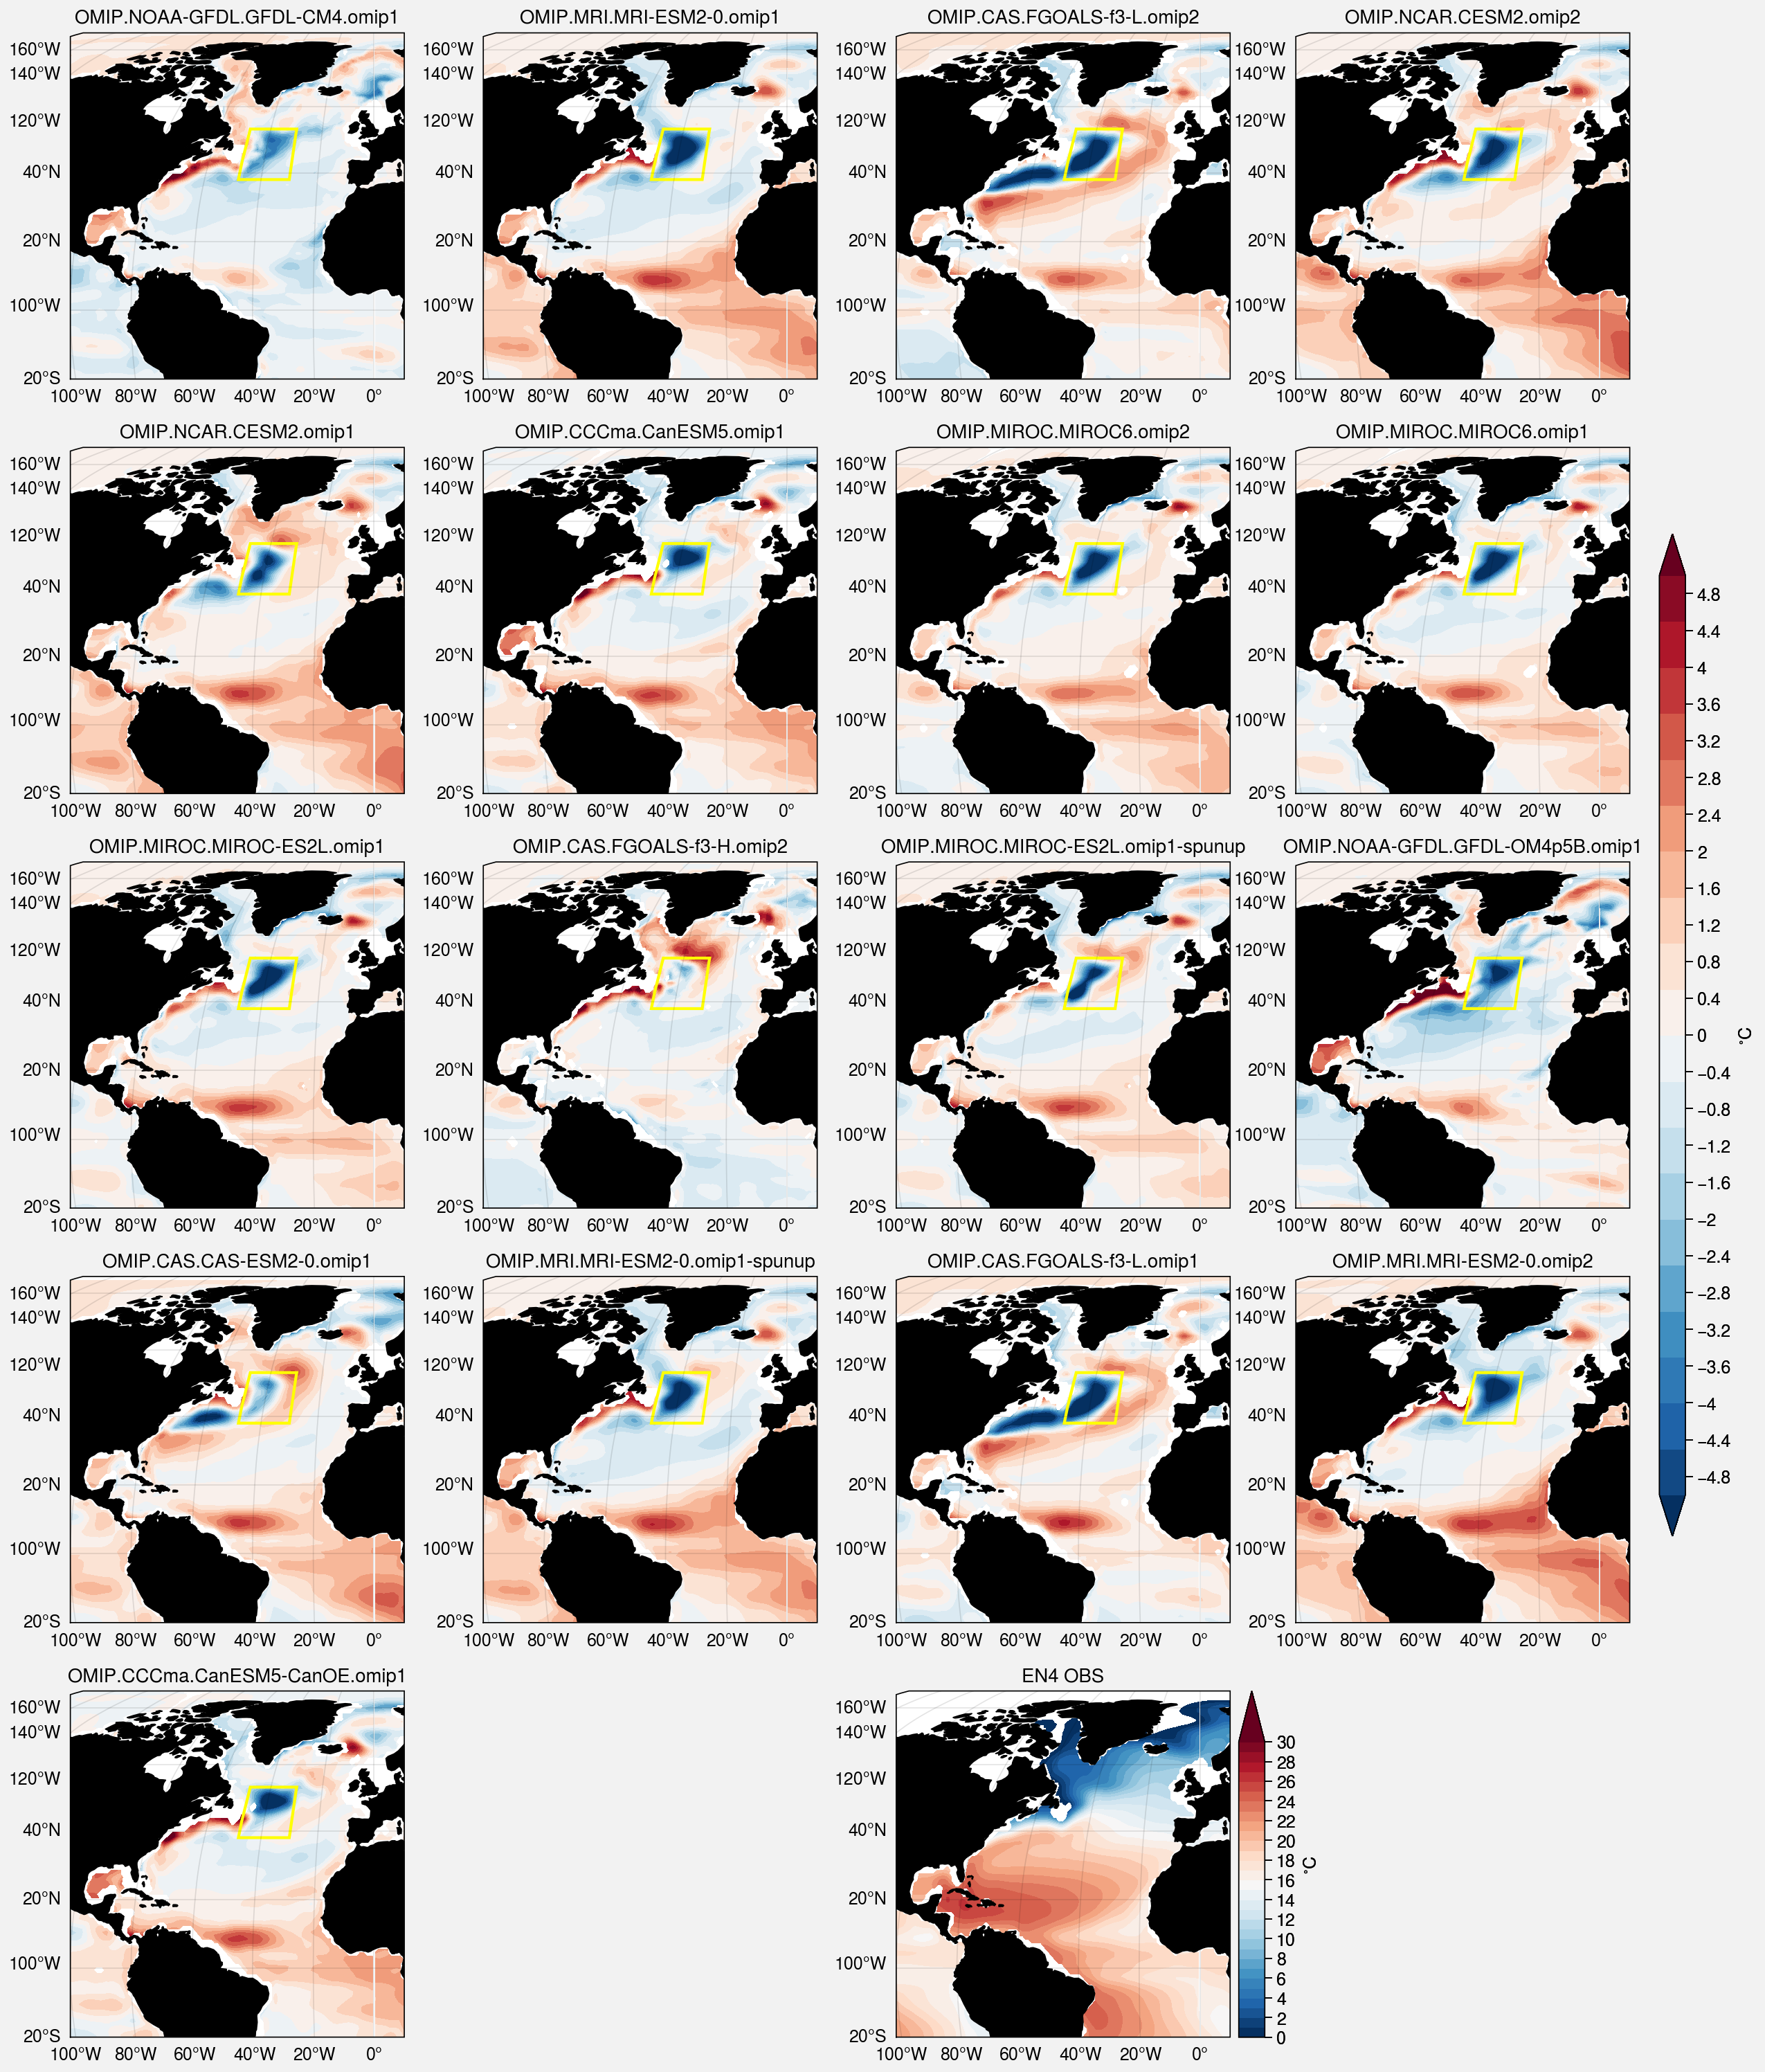

In [139]:
%%time
import proplot as plot
import matplotlib.patches as mpatches

keys = [varname for varname, da in ds.data_vars.items()]
nplot = len(keys)
ncol = 4
nrows = round(nplot/ncol + 0.5)
array = [  # the "picture" (0 == nothing, 1 == subplot A, 2 == subplot B, etc.)
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16],
    [17, 0, 18, 0],
]
fig, axes = plot.subplots(array, proj='robin', proj_kw={'lon_0': 0})
tlevs = np.linspace(-5,5,21)
extent = [-100, 10, -20, 90]
for index, (key, da) in enumerate(meant.items()):
    assert len(meant[key].dims) == 2
    m = axes[index].contourf(meant[key], levels=tlevs,
                             transform=ccrs.PlateCarree(),extend='both',cmap='RdBu_r')
    axes[index].format(title=keys[index].replace('_thetao_0-200m_bias',''))
    axes[index].add_patch(mpatches.Rectangle(xy=[-48, 38], width=18, height=15,
                                    facecolor=None, edgecolor='yellow',fill=False,linewidth=1.5,
                                    transform=ccrs.PlateCarree()))
    axes[index].set_extent(extent)

tfulllevs = np.linspace(0,30,31)
n = axes[17].contourf(dsen4.thetao_200m_mean.mean('month'), levels=tfulllevs,
                             transform=ccrs.PlateCarree(),extend='max',cmap='RdBu_r')
axes[17].format(title='EN4 OBS')
axes[17].set_extent(extent)
axes[17].colorbar(n, label='$^{\circ}$C', ticks=2, loc='r')

axes.format(land=True, coast=True, lonlabels=True, latlabels=True)
fig.colorbar(m, label='$^{\circ}$C', ticks=0.4, loc='r', length=0.5)
plt.savefig('CMIP6_thetao_0-200m_bias.pdf')

CPU times: user 32.6 s, sys: 214 ms, total: 32.8 s
Wall time: 33 s


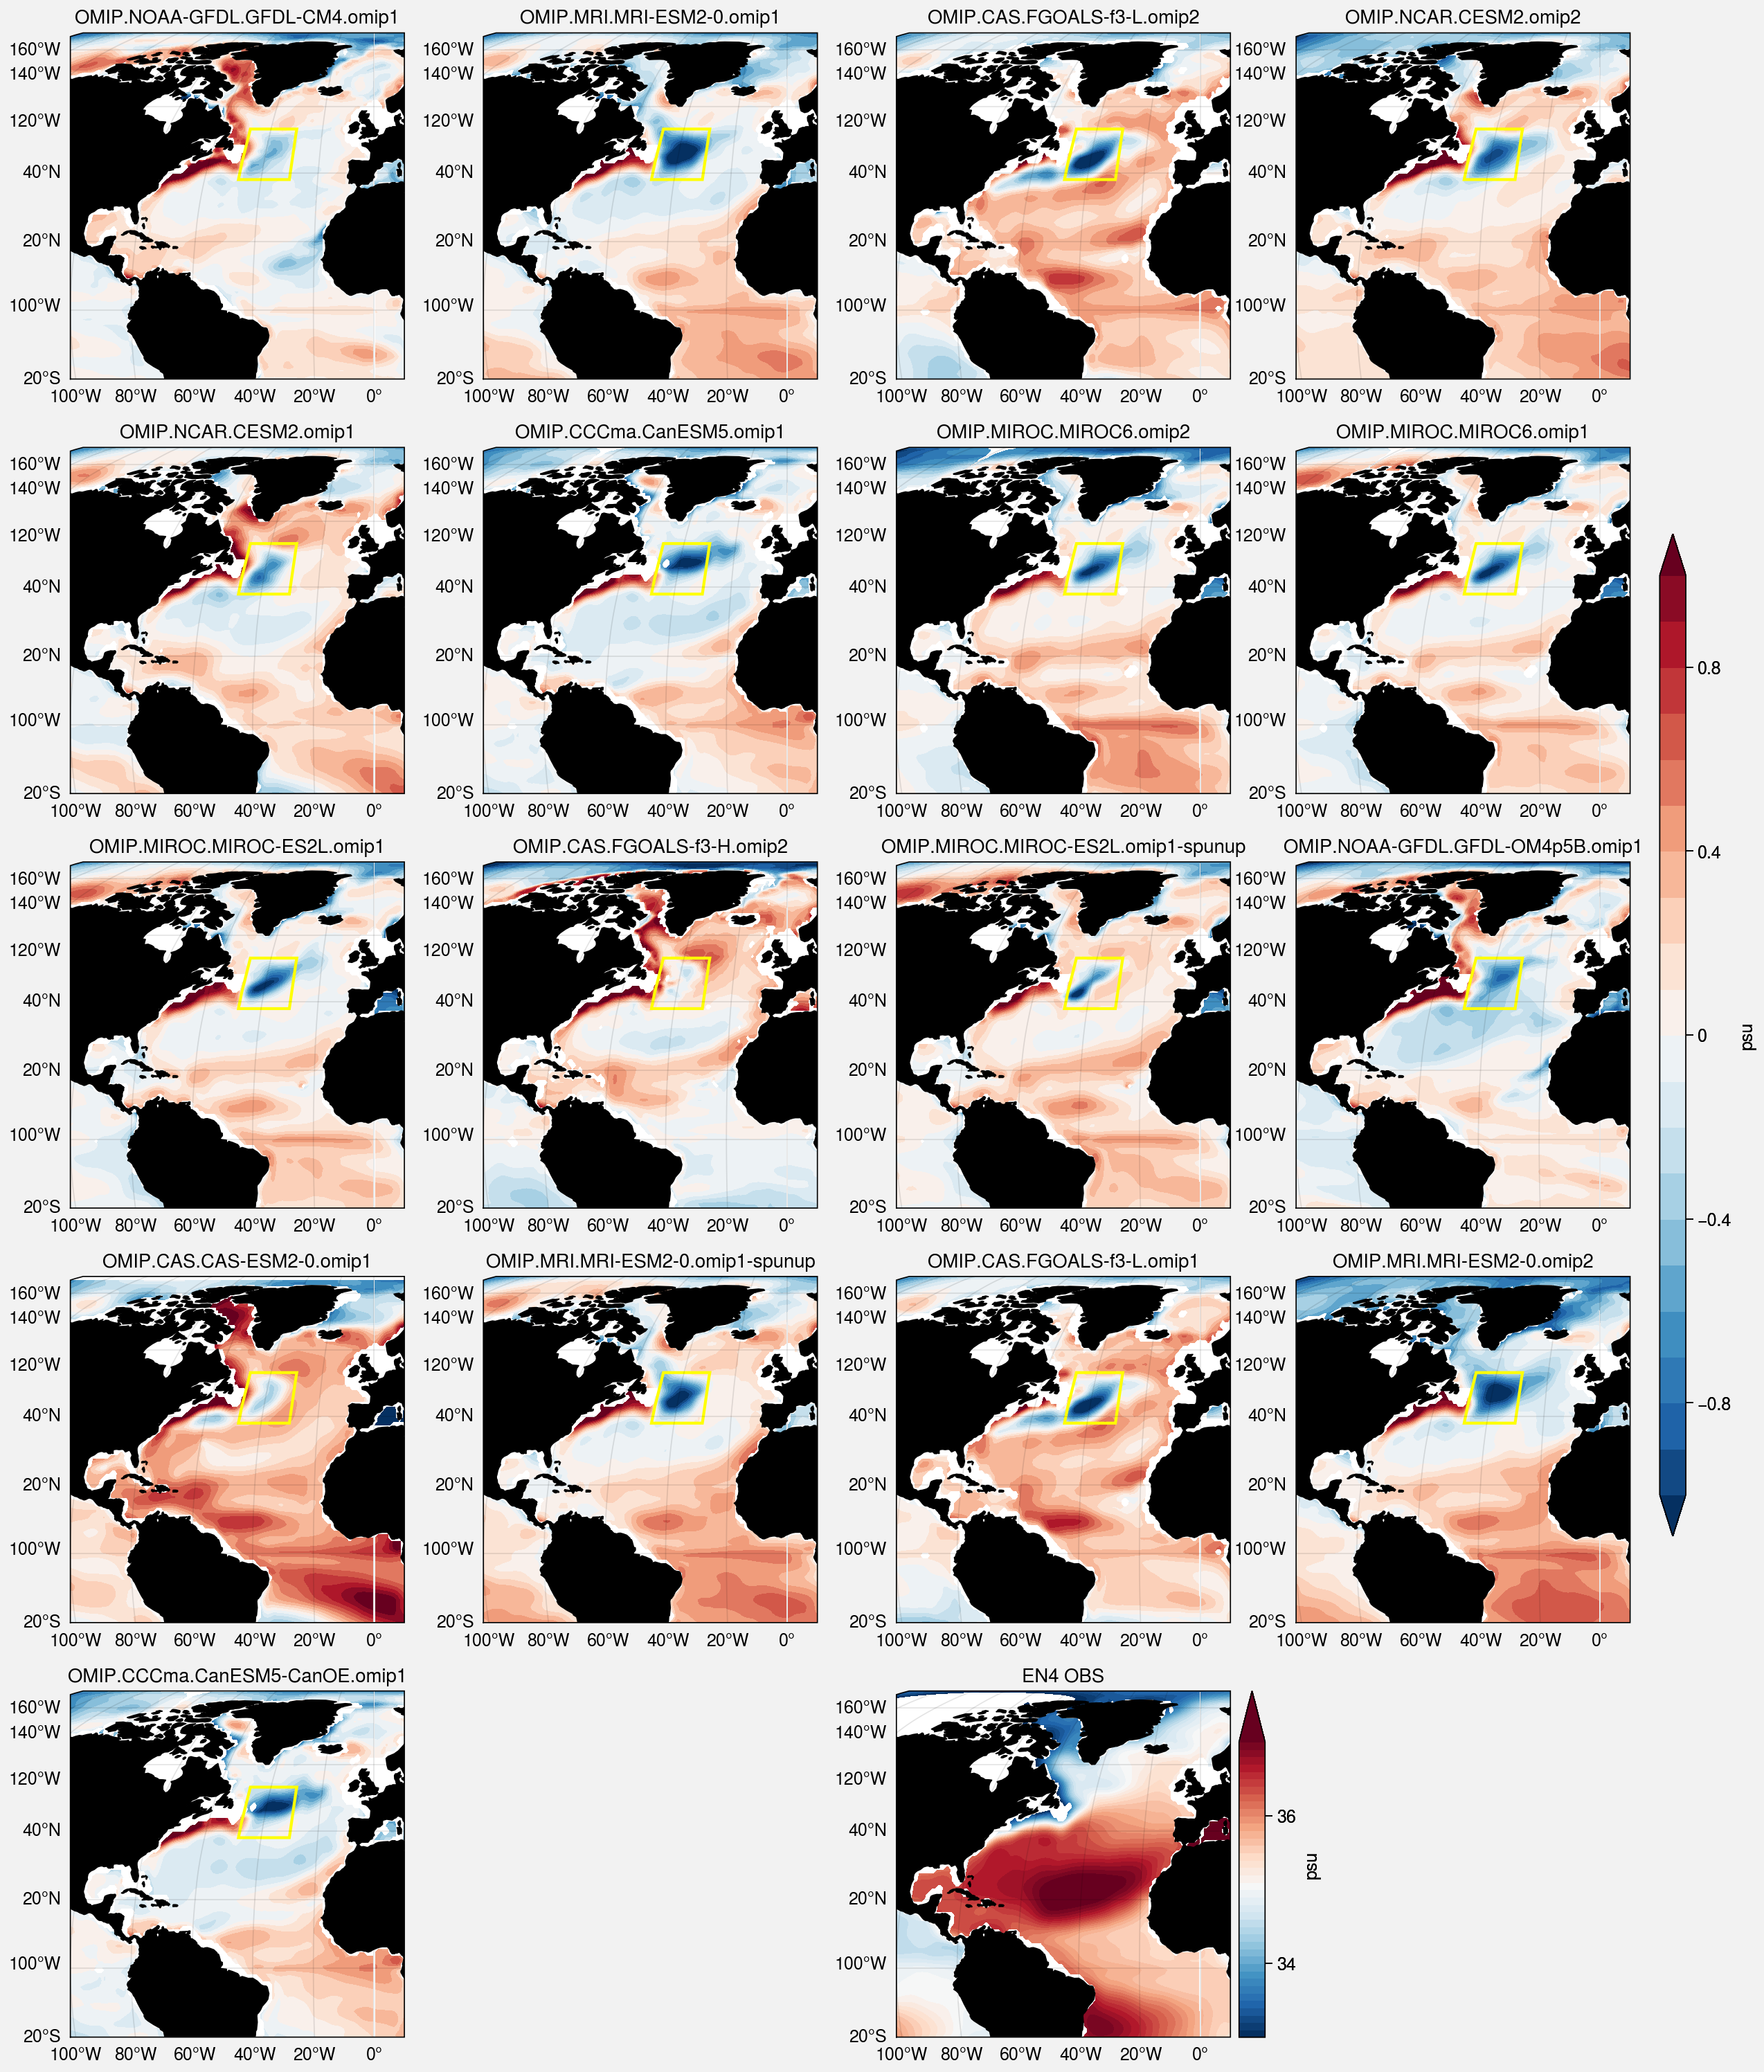

In [138]:
%%time
import proplot as plot
import matplotlib.patches as mpatches

keys = [varname for varname, da in ds.data_vars.items()]
nplot = len(keys)
ncol = 4
nrows = round(nplot/ncol + 0.5)
array = [  # the "picture" (0 == nothing, 1 == subplot A, 2 == subplot B, etc.)
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16],
    [17, 0, 18, 0],
]
fig, axes = plot.subplots(array, proj='robin', proj_kw={'lon_0': 0})
slevs = np.linspace(-1,1,21)
extent = [-100, 10, -20, 90]
for index, (key, da) in enumerate(means.items()):
    assert len(means[key].dims) == 2
    m = axes[index].contourf(means[key], levels=slevs,
                             transform=ccrs.PlateCarree(),extend='both',cmap='RdBu_r')
    axes[index].format(title=keys[index].replace('_thetao_0-200m_bias',''))
    axes[index].add_patch(mpatches.Rectangle(xy=[-48, 38], width=18, height=15,
                                    facecolor=None, edgecolor='yellow',fill=False,linewidth=1.5,
                                    transform=ccrs.PlateCarree()))
    axes[index].set_extent(extent)

sfulllevs = np.linspace(33,37,41)
n = axes[17].contourf(dsen4.so_200m_mean.mean('month'), levels=sfulllevs,
                             transform=ccrs.PlateCarree(),extend='max',cmap='RdBu_r')
axes[17].format(title='EN4 OBS')
axes[17].set_extent(extent)
axes[17].colorbar(n, label='psu', ticks=2, loc='r')

axes.format(land=True, coast=True, lonlabels=True,latlabels=True)
fig.colorbar(m, label='psu', ticks=0.4, loc='r', length=0.5)
plt.savefig('CMIP6_so_0-200m_bias.pdf')